# TRABAJO PRACTICO APRENDIZAJE PROFUNDO PARA EL PROCESAMIENTO DE LA SEÑAL BIOMÉTRICA

**Alumnos:** 
 - Rocío Rico Sanchez-Mateos
 - Iker Villegas Labairu

Antes de comenzar vamos a importar todos los paquetes que vamos a utilizar a lo largo del trabajo.

In [1]:
import cv2
import numpy as np
#import tensorflow.keras.models as Models
#from tensorflow.keras.layers import Flatten
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import face_recognition_functions as frf
import os
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.metrics import accuracy_score

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\dnn\src\caffe\caffe_io.cpp:1138: error: (-2:Unspecified error) FAILED: fs.is_open(). Can't open "res10_300x300_ssd_iter_140000.caffemodel" in function 'cv::dnn::ReadProtoFromBinaryFile'


Ahora vamos a definir todas las funciones que se van a llamar a lo largo del trabajo

In [2]:
def obtain_data_embedding(carpeta, n_identidades : int, n_archivos : int):
    ''' 
    Obtención de la lista de embeddings para un conjunto de archivos pertenecientes a un directorio local

    PARAMETROS
    ------------
    v_carpeta: lista de carpetas donde se encuentran los archivos a usar
    n_identidades: número de identidades a analizar
    n_archivos: número de imágenes por identidad 

    SALIDA
    ------------
    X: matriz de datos con los embeddings situados por filas
    y: lista con las etiquetas por género para cada embedding
    '''
    X=[] # lista de embedings
    y=[] # lista de etiquetas 
    
    #for carpeta in v_carpeta:

    aux = 0 #controlador para el número de identidades
    directorio = "4K_120\\" + carpeta #contruimos el directorio a recorrer

    # Recorremos de manera recursiva todos los archivos y carpetas en la ruta especificada
    for ruta, carpetas, archivos in os.walk(directorio):

        # Recorremos todos los archivos en la carpeta actual
        for archivo in archivos[0:n_archivos]:

            # Generamos la ruta completa del archivo
            ruta_archivo = os.path.join(ruta, archivo)
            img =  cv2.imread(ruta_archivo, cv2.IMREAD_UNCHANGED)

            #Extraemos los embeddings del archivo
            embeddings = frf.generate_embedding(img)

            #Agregamos los embeddings a la lista 
            X.append(embeddings[0])

            #Agregamos la etiqueta a la lista
            if carpeta[0] == 'H':
                y.append(0)
            else:
                y.append(1)

            # Parar bucle 
            aux = aux +1
            if aux>=n_identidades:
                break
        else:
            continue
        break
    
    X = np.array(X)
    return X,y



def similitud_embedding(x, y):
    ''' 
    Obtención de similaridad entre dos embeddings

    PARAMETROS
    ------------
    x: primer embedding
    y: segundo embedding

    SALIDA
    ------------
    sim: valor de similaridad entre los dos embeddings
    '''
    embedding_x = np.asarray(x)
    f1 = np.squeeze(embedding_x) #función que convierte el embedding en un elemento unidimensional
    embedding_y = np.asarray(y)
    f2 = np.squeeze(embedding_y)

    # Similaridad basada en el producto vectorial. Valores altos significan alta similaridad
    sim=np.dot(f1, f2.T)

    return sim



def get_scores(x):
    ''' 
    Obtención de dos listas con las puntuaciones de similaridad clasificadas según sean genuinos o impostores

    PARAMETROS
    ------------
    x: lista de embeddings

    SALIDA
    ------------
    score_genuino: lista con las puntuaciones clasificadas como genuinas
    score_impostor: lista con las puntuaciones clasificadas como impostoras
    '''
    score_genuino = [] #lista para almacenar las puntuaciones genuinas
    score_impostor = [] #lista para almacenar las puntuaciones impostoras

    length = len(x) #longitud de la lista de entrada
    index_jpg = [i for i in range(length)] #lista para controlar que no se repitan comparaciones

    for i in range(length):
        
        for j in index_jpg:
            if i!=j:
                #print(f"comparacion: {i}, {j}")
                sim = similitud_embedding(x[i],x[j]) #calculo de la similaridad

                #clasificación a genuino o impostor en base a si supera el valor 0.5
                if sim>=0.50:
                    score_genuino.append(sim)
                else:
                    score_impostor.append(sim)
        
        #eliminamos el índice para evitar que se repita la comparación en el caso inverso 
        index_jpg.remove(i)

    return score_genuino, score_impostor

    

def curva_ROC(score_genuino, score_impostor):
    
    sorted_genuino = sorted(score_genuino)
    sorted_impostor = sorted(score_impostor)
    
    ax = pd.DataFrame(sorted_genuino).plot(kind='density')
    pd.DataFrame(sorted_impostor).plot(ax=ax,kind='density')
    #ax.axvline(0.434, color='g', linestyle='--')
    ax.legend(["Genuines Distribution","Impostors Distribution"])
    #ax.text(0.38,-0.3,"FRR")
    #ax.text(0.45,-0.3,"FAR")
    plt.xlabel("Matching score value")

    plt.show()


# EJECUCIÓN

Creamos los embedings de las imágenes para obtener datasets de entrenamiento y test para todas las etnias.

In [3]:
def obtain_train_test(v_carpeta, n_identidades = 750, n_archivos = 1):

    index_train = 500

    X_0, y_0 = obtain_data_embedding(v_carpeta[0], n_identidades, n_archivos) #hombres
    X_1, y_1 = obtain_data_embedding(v_carpeta[1], n_identidades, n_archivos) #mujeres

    ## DATOS DE ENTRENAMIENTO
    # Seleccionamos una parte de los datos de embeding 
    X = list(X_0[0:index_train]) + list(X_1[0:index_train]) 
    y = y_0[0:index_train] + y_1[0:index_train]
    # Los arreglamos para ser argumentos adecuados para el fit
    X_train = np.array(X).astype(float)              
    y_train = np_utils.to_categorical(np.asarray(y))

    ## DATOS DE TEST
    # Seleccionamos una parte de los datos de embeding 
    index_test = index_train # 30% de los datos
    X = list(X_0[index_test:]) + list(X_1[index_test:])
    y = y_0[index_test:] + y_1[index_test:]
    # Los arreglamos para ser argumentos adecuados para el fit
    X_test = np.array(X).astype(float) 
    y_test = np_utils.to_categorical(np.asarray(y))

    return X_train, y_train, X_test, y_test

x_train_A, y_train_A, x_test_A, y_test_A = obtain_train_test(["HA4K_120","MA4K_120"])
x_train_B, y_train_B, x_test_B, y_test_B = obtain_train_test(["HB4K_120","MB4K_120"])
x_train_N, y_train_N, x_test_N, y_test_N = obtain_train_test(["HN4K_120","MN4K_120"])

1/1 [==============================] - 0s 148ms/step


Para hacernos una idea de los datos generados graficamos sus curvas ROC

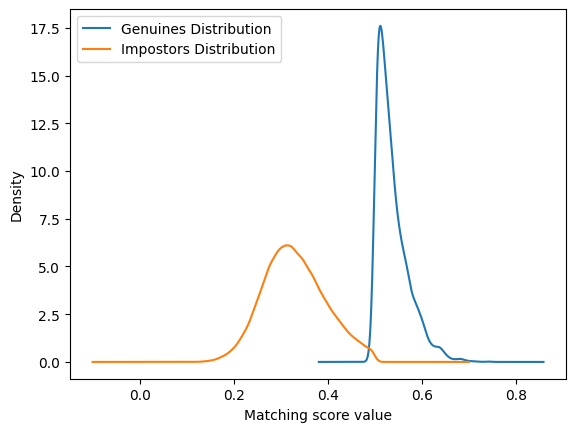

In [4]:
# Curva ROC asiáticos
score_genuino_A, score_impostor_A = get_scores(x_test_A)
curva_ROC(score_genuino_A,score_impostor_A)

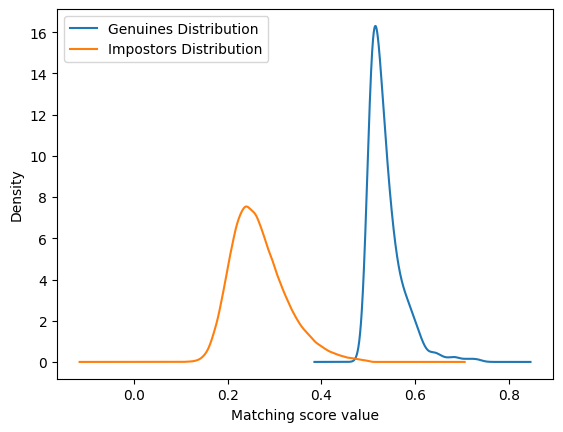

In [33]:
# Curva ROC caucásicos
score_genuino_B, score_impostor_B = get_scores(x_test_B)
curva_ROC(score_genuino_B,score_impostor_B)

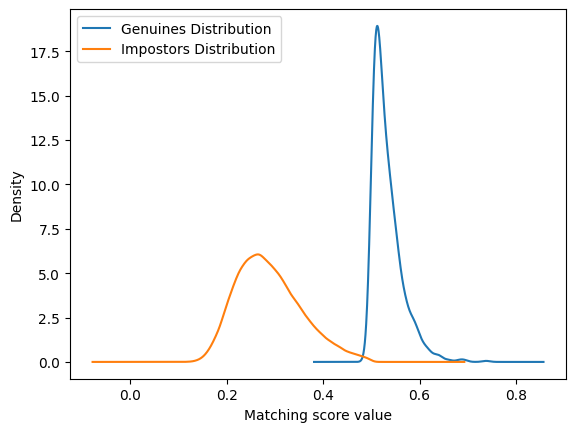

In [34]:
# Curva ROC negros
score_genuino_N, score_impostor_N = get_scores(x_test_N)
curva_ROC(score_genuino_N,score_impostor_N)

#### **TASK 2.1**: Entrenar 3 clasificadores de género diferentes usando imágenes del mismo grupo étnico

Para llevar el entrenamiento a cabo, vamos a crear 3 clasificadores los cuales entrenaremos usando únicamente imágenes de uno de los 3 grupos étnicos para cada uno: _estimator_modelA_ el correspondiente a los asiáticos, _estimator_modelB_ para los caucásicos y _estimator_modelN_ el cuál será entrenado usando únicamente imágenes de personas negras.

In [5]:
# Se crea un modelo para el clasificador
#input_size = 2048
def baseline_model():
    model = Sequential()
    model.add(Dense(60, input_dim=2048, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Se crea el clasificador 
estimator_modelA = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
estimator_modelB = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
estimator_modelN = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17132\2109091981.py:11: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator_modelA = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17132\2109091981.py:12: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator_modelB = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17132\2109091981.py:13: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator_mode

Una vez creados los clasificadores, vamos a entrenarlos usando los conjuntos de datos de entrenamiento que hemos generado con anterioridad. Para cada uno de ellos se utilizarán 1000 imágenes: 500 correspondientes a hombres y la otra mitad a mujeres.

In [26]:
# Entrenamiento del clasificador
estimator_modelA.fit(x_train_A, y_train_A) #grupo asiático
estimator_modelB.fit(x_train_B, y_train_B) #grupo caucásico
estimator_modelN.fit(x_train_N, y_train_N) #grupo negro

Y con esto ya tenemos creados y entrenados nuestros tres clasificadores.


### **TASK 2.2**: Evaluar los tres clasificadores de género usando imágenes de cada uno de los tres grupos étnicos.

Para llevar a cabo esta segunda tarea, evaluaremos cada uno de los tres clasificadores usando 3 conjuntos de 500 imágenes test de cada uno de los grupos étnicos, donde mitad son mujeres y la otra mitad hombres.

#### Modelo A: entrenado a base de imágenes de etnia asiática.

Vamos a sacar la precisión evaluando el modelo con imágenes de las 3 etnias consideradas.

In [27]:
# Predicción 
y_pred_A = estimator_modelA.predict(x_test_A) # asiáticos
y_pred_A = np_utils.to_categorical(y_pred_A)
y_pred_B = estimator_modelA.predict(x_test_B) # blancos
y_pred_B = np_utils.to_categorical(y_pred_B)
y_pred_N = estimator_modelA.predict(x_test_N) # negros
y_pred_N = np_utils.to_categorical(y_pred_N)

# Resultados
score_AA = accuracy_score(y_test_A, y_pred_A)
score_AB = accuracy_score(y_test_B, y_pred_B)
score_AN = accuracy_score(y_test_N, y_pred_N)

16/16 [==============================] - 0s 3ms/step


In [28]:
print("La predicción para asiáticos entrenando con asiáticos tiene un escore de: ",score_AA)
print("La predicción para caucásicos entrenando con asiáticos tiene un escore de: ",score_AB)
print("La predicción para negros entrenando con asiáticos tiene un escore de: ",score_AN)

La predicción para asiáticos entrenando con asiáticos tiene un escore de:  0.99
La predicción para caucásicos entrenando con asiáticos tiene un escore de:  0.848
La predicción para negros entrenando con asiáticos tiene un escore de:  0.94


#### Modelo B: entrenado a base de imágenes de etnia caucásica.

Ahora repitamos el procedimiento anterior utilizando el modelo entrenado con imágenes procedentes del grupo caucásico.

In [29]:
# Predicción 
y_pred_A = estimator_modelB.predict(x_test_A) # asiáticos
y_pred_A = np_utils.to_categorical(y_pred_A)
y_pred_B = estimator_modelB.predict(x_test_B) # blancos
y_pred_B = np_utils.to_categorical(y_pred_B)
y_pred_N = estimator_modelB.predict(x_test_N) # negros
y_pred_N = np_utils.to_categorical(y_pred_N)

# Resultados
score_BA = accuracy_score(y_test_A, y_pred_A)
score_BB = accuracy_score(y_test_B, y_pred_B)
score_BN = accuracy_score(y_test_N, y_pred_N)

16/16 [==============================] - 0s 3ms/step


In [30]:
print("La predicción para asiáticos entrenando con caucásicos tiene un escore de: ",score_BA)
print("La predicción para caucásicos entrenando con caucásicos tiene un escore de: ",score_BB)
print("La predicción para negros entrenando con caucásicos tiene un escore de: ",score_BN)

La predicción para asiáticos entrenando con caucásicos tiene un escore de:  0.852
La predicción para caucásicos entrenando con caucásicos tiene un escore de:  0.988
La predicción para negros entrenando con caucásicos tiene un escore de:  0.912


#### Modelo N: entrenado a base de imágenes de etnia negra.

Por último hagamos lo propio para el último modelo correspondiente al grupo de etnia negra.

In [31]:
# Predicción 
y_pred_A = estimator_modelN.predict(x_test_A) # asiáticos
y_pred_A = np_utils.to_categorical(y_pred_A)
y_pred_B = estimator_modelN.predict(x_test_B) # blancos
y_pred_B = np_utils.to_categorical(y_pred_B)
y_pred_N = estimator_modelN.predict(x_test_N) # negros
y_pred_N = np_utils.to_categorical(y_pred_N)

# Resultados
score_NA = accuracy_score(y_test_A, y_pred_A)
score_NB = accuracy_score(y_test_B, y_pred_B)
score_NN = accuracy_score(y_test_N, y_pred_N)


16/16 [==============================] - 0s 3ms/step


In [32]:
print("La predicción para asiáticos entrenando con negros tiene un escore de: ",score_NA)
print("La predicción para caucásicos entrenando con negros tiene un escore de: ",score_NB)
print("La predicción para negros entrenando con negros tiene un escore de: ",score_NN)

La predicción para asiáticos entrenando con negros tiene un escore de:  0.83
La predicción para caucásicos entrenando con negros tiene un escore de:  0.876
La predicción para negros entrenando con negros tiene un escore de:  0.962


#### Matriz de precisión

La matriz de precisión de nuestros clasificadores para distinguir entre géneros es la siguiente: 
\begin{equation*}
Accuracy \; score=
\begin{pmatrix}
0.984 & 0.844 & 0.948\\
0.838 & 0.988 & 0.912\\
0.822 & 0.886 & 0.964
\end{pmatrix}
\end{equation*}
donde cada fila de resultados ha sido entrenada con datasets siguiendo el mismo orden que el de evaluación de las columnas: asiáticos, caucásicos y negros.

Como esperábamos la diagonal es la que mayores valores posee ya que esos datos predicen sobre la misma etnia con la que han sido entrenados. A parte de eso encontramos relaciones interesantes como que aparentemente los más fáciles de clasificar según género sean las personas de raza negra independientemente de los datos de entrenamiento. Por el contrario, la etnia más difícil por la máquina de distinguir es la asiática. Esto en primera instancia podría sugerir que el dimorfismo de humanos se ve más acentuado en etnias negras mientras que los asiáticos tienden hacia la unificación de los caracteres sexuales pero no hay que dejar pasar las diferencias culturales en atributos variables como el corte de pelo, maquillaje, gafas, depilado de cejas o barba, incluso la tendencia a sonreir en fotos o el ideal de peso de cada país, etc. Para corroborar estas influencias tendríamos que hacer un estudio mucho más exahustivo pudiendo aún así no dar con la verdadera causa por la cual nuestro clasificador toma las decisiones que hace. Por último comentar que el entrenamiento que mayor precisión consigue es el entrenamiento con asiáticos. Este hecho coincide con lo descrito anteriormente ya que si nuestro programa es capaz de captar las sutilezas que distinguen a unos de otros en etnias más uniformes le resultará fácil extrapolar ese conocimiento al resto, es por esto mismo, que la entrenada con personas negras devuelve los peores resultados al haberse especializado en características divergentes más obvias y tener que moverse a datos con mayor complejidad de análisis. 

### **TASK 2.3**: Entrenar un clasificador de género usando imágenes de los tres grupos étnicos. 

In [16]:
estimator_model_total = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9316\2226731418.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator_model_total = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)


In [ ]:
# Entrenamiento del clasificador
y_test_total = np_utils.to_categorical(np.asarray(y_total))
estimator_model_total.fit(x_train_total, y_train_total)

### **TASK 2.4**: Evaluar el clasificador de género previo usando imágenes de cada uno de los tres grupos étnicos.



In [ ]:


# Predicción 
y_pred_A = estimator_model_total.predict(x_test_A) # asiáticos
y_pred_A = np_utils.to_categorical(y_pred_A)
y_pred_B = estimator_model_total.predict(x_test_B) # blancos
y_pred_B = np_utils.to_categorical(y_pred_B)
y_pred_N = estimator_model_total.predict(x_test_N) # negros
y_pred_N = np_utils.to_categorical(y_pred_N)
#y_pred_total = estimator_model_total.predict(x_test_total) # total
#y_pred_total = np_utils.to_categorical(y_pred_total)

# Resultados
score_AA = accuracy_score(y_test_A, y_pred_A)
score_AB = accuracy_score(y_test_B, y_pred_B)
score_AN = accuracy_score(y_test_N, y_pred_N)
#score_total = accuracy_score(y_test_total, y_pred_total)


47/47 [==============================] - 0s 3ms/step
La predicción para asiáticos entrenando con las 3 etnias tiene un escore de:  0.994
La predicción para caucásicos entrenando con las 3 etnias tiene un escore de:  0.988
La predicción para negros entrenando con las 3 etnias tiene un escore de:  0.972
La predicción para todas las etnias entrenando con las 3 etnias tiene un escore de:  0.9846666666666667


In [ ]:
print("La predicción para asiáticos entrenando con las 3 etnias tiene un escore de: ",score_AA)
print("La predicción para caucásicos entrenando con las 3 etnias tiene un escore de: ",score_AB)
print("La predicción para negros entrenando con las 3 etnias tiene un escore de: ",score_AN)
#print("La predicción para todas las etnias entrenando con las 3 etnias tiene un escore de: ",score_total)

#### Similitud entre razas

Para poder entender mejor los análisis posteriores vamos a ver en la siguiente gráfica la similitud que hay entre razas. Vamos a ayudarnos de la función TSNE que convierte los vectores embeding en vectores de dos dimensiones para poder se capaz de visualizarlos. El valor de las coordenadas ahora representan la similitud con el resto de datos.

In [35]:
def representacion_TSNE(XA,XB,XN,n_components = 2, perplexity = 30):
    #TO DO: ploteo de los embeddings
    """ 
    La función TSNE coge vectores y los reduce a dimensión = n_components, en este caso =2. 
    Los valores del vector nuevo [x0,x1] se sacan en proporción a la distancia con el resto de sus vecinos
    No tiene atributo .transform(), por lo que pese a que se puede entrenar para una sola clase con .fit(),
    no se puede evaluar otras clases para ese entrenamiento. Solo se queda hacer .fit_transform() a la vez.

    """
    tsne_model = TSNE(n_components=n_components, learning_rate='auto',init='random',perplexity=perplexity)

    # Hombres y mujeres
    xH_embedded = tsne_model.fit_transform(np.concatenate((XA[0:500],XB[0:500],XN[0:500])))
    xM_embedded = tsne_model.fit_transform(np.concatenate((XA[500:1000],XB[500:1000],XN[500:1000])))
    # Ambos géneros
    x_embedded = tsne_model.fit_transform(np.concatenate((XA,XB,XN)))


    ## PLOTS ##
    figH = plt.figure()
    axH=figH.add_subplot()
    axH.scatter(xH_embedded[0:500,0], xH_embedded[0:500,1],label='Asiáticos',color='blue',alpha=0.8)
    axH.scatter(xH_embedded[500:1000,0], xH_embedded[500:1000,1],label='Caucásicos',color='red',alpha=0.8)
    axH.scatter(xH_embedded[1000:1500,0], xH_embedded[1000:1500,1],label='Negros',color='green',alpha=0.8)
    axH.set_title('Similitud entre razas para hombres')
    axH.legend()

    figM = plt.figure()
    axM=figM.add_subplot()
    axM.scatter(xM_embedded[0:500,0], xM_embedded[0:500,1],label='Asiáticas',color='blue',alpha=0.8)
    axM.scatter(xM_embedded[500:1000,0], xM_embedded[500:1000,1],label='Caucásicas',color='red',alpha=0.8)
    axM.scatter(xM_embedded[1000:1500,0], xM_embedded[1000:1500,1],label='Negras',color='green',alpha=0.8)
    axM.set_title('Similitud entre razas para mujeres')
    axM.legend()

    fig = plt.figure()
    ax=fig.add_subplot()
    ax.scatter(x_embedded[0:1000,0], x_embedded[0:1000,1],label='Asiáticos',color='blue',alpha=0.8)
    ax.scatter(x_embedded[1000:2000,0], x_embedded[1000:2000,1],label='Caucásicos',color='red',alpha=0.8)
    ax.scatter(x_embedded[2000:3000,0], x_embedded[2000:3000,1],label='Negros',color='green',alpha=0.8)
    ax.set_title('Similitud entre razas')
    ax.legend()

    plt.show()
    
    return 0
    


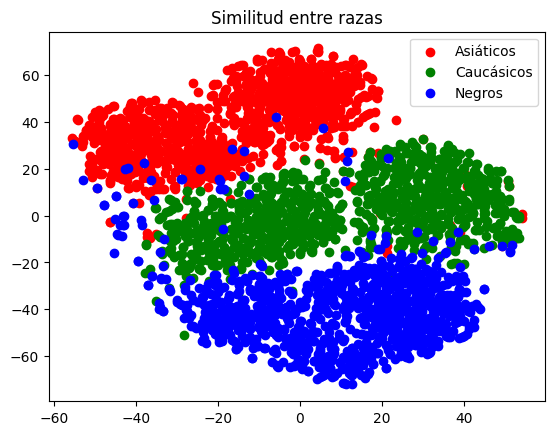

In [36]:
representacion_TSNE(x_train_A,x_train_B,x_train_N)

-De la primera figura podemos afirmar que en hombres la diferencias entre etnias está muy marcada sin una aparente acercamiento de unas sobre otras. Hay tres clases bien diferenciadas pese a que los colores cerca del centro sean más heterogénos o haya outliers. 
    
-De la segunda figura también podemos decir que hay tres clases diferenciadas pero además, hay que añadir que se aprecia una mayor similitud entre mujeres caucasicas y negras respecto de las asiaticas. Dentro de este grupo, las caucásicas se presentan más cercanas a las asiáticas que las mujeres negras. 

-De la tercera figura podemos observar las diferentes ideas presentadas en las anteriores gráficas: se dividen los datos en tres grupos bien diferenciados representando las tres etnias y en cada subgrupo existe una división por las diferencias de género. Podemos apreciar que puntos se refieren a mujeres si buscamos cuales son las mitades más próximas para caucásicos y negros como se explicaba en el punto anterior. Fuera de estas obervaciones antes mencionadas hay que destacar como la brecha que producen las características sexuales se difumina para los asiáticos pero abre paso entre los datos de las personas caucásicas y negras ya que va a comentarse en análisis posteriores.
    